In [245]:
"""
Analysis pipeline on BERT models
"""

import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoModelForCausalLM, AutoModelForMaskedLM, BertModel, AlbertModel, DistilBertModel, RobertaModel, BartModel, OpenAIGPTModel, GPT2Model

In [220]:
def decomposition_SN(A):
    
    S = np.linalg.norm(.5 * (A + A.T), 'fro') / np.linalg.norm(A, 'fro')
    N = np.linalg.norm(.5 * ((A - A.T)), 'fro') / np.linalg.norm(A, 'fro')

    return S, N

def decomposition_blocks(d,l,h,dh,A):
    S = np.zeros((l,h))
    N = np.zeros((l,h))

    for i, layer in enumerate(range(l)):
        for j, head in enumerate(range(0,d,dh)):
            S[i,j], N[i,j] = decomposition_SN(A[layer][head:head+dh,head:head+dh])
    return  S, N

In [242]:
def get_matricesBERT(model):

    layers = len(model.encoder.layer)    
    M = []
    for l in range(layers):
        Wq = model.encoder.layer[l].attention.self.query.weight.detach().numpy()
        Wk = model.encoder.layer[l].attention.self.key.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesALBERT(model):

    layers = len(model.encoder.albert_layer_groups)    
    M = []
    for l in range(layers):
        Wq = model.encoder.albert_layer_groups[l].albert_layers[0].attention.query.weight.detach().numpy()
        Wk = model.encoder.albert_layer_groups[l].albert_layers[0].attention.key.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesDistillBERT(model):

    layers = len(model.transformer.layer)
    M = []
    for l in range(layers):
        Wq = model.transformer.layer[l].attention.q_lin.weight.detach().numpy()
        Wk = model.transformer.layer[l].attention.k_lin.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesBART(model):

    layers = len(model.encoder.layers)  
    M = []
    for l in range(layers):
        Wq = model.encoder.layers[l].self_attn.q_proj.weight.detach().numpy()
        Wk = model.encoder.layers[l].self_attn.k_proj.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesGPT(d,model):

    layers = len(model.h)  
    M = []
    for l in range(layers):
        Wq = model.h[l].attn.c_attn.weight[:,:d].detach().numpy()
        Wk = model.h[l].attn.c_attn.weight[:,d:2*d].detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesDistillGPT(d,model):

    layers = len(model.transformer.h)  
    M = []
    for l in range(layers):
        Wq = model.transformer.h[l].attn.c_attn.weight[:,:d].detach().numpy()
        Wk = model.transformer.h[l].attn.c_attn.weight[:,d:2*d].detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

In [223]:
""" 

BERT models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""
dh = 64

l = 2
d = 128
h = d // dh

model = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
M = get_matricesBERT(model)
SBert_tiny, NBert_tiny = decomposition_blocks(d,l,h,dh,M)

l = 4
d = 256
h = d // dh

model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4")
M = get_matricesBERT(model)
SBert_mini, NBert_mini = decomposition_blocks(d,l,h,dh,M)


l = 4
d = 512
h = d // dh

model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
M = get_matricesBERT(model)
SBert_small, NBert_small = decomposition_blocks(d,l,h,dh,M)

l = 8
d = 512
h = d // dh

model = AutoModel.from_pretrained("google/bert_uncased_L-8_H-512_A-8")
M = get_matricesBERT(model)
SBert_medium, NBert_medium = decomposition_blocks(d,l,h,dh,M)

l = 12
d = 768
h = d // dh

model = BertModel.from_pretrained("bert-base-uncased")
M = get_matricesBERT(model)
SBert_base, NBert_base = decomposition_blocks(d,l,h,dh,M)

l = 24
d = 1024
h = d // dh

model = BertModel.from_pretrained("bert-large-uncased")
M = get_matricesBERT(model)
SBert_large, NBert_large = decomposition_blocks(d,l,h,dh,M)

l = 24
d = 1024
h = d // dh

model = BertModel.from_pretrained("bert-large-uncased-whole-word-masking")
M = get_matricesBERT(model)
SBert_largeMasking, NBert_largeMasking = decomposition_blocks(d,l,h,dh,M)

In [224]:
""" 
Generative Pre-trained Transformer (GPT)


Fine-tuning approach: introduce minimal, task-specific parameters, and is trained on downstream tasks by fine-tuning all pre-trained parameters
"""

dh = 64

'GPT 1'

l = 12
d = 768
h = d // dh
model = OpenAIGPTModel.from_pretrained("openai-gpt")
M = get_matricesGPT(d,model)
SGPT, NGPT = decomposition_blocks(d,l,h,dh,M)

'GPT2'

l = 12
d = 768
h = d // dh
model = GPT2Model.from_pretrained('gpt2')
M = get_matricesGPT(d,model)
SGPT2, NGPT2 = decomposition_blocks(d,l,h,dh,M)

'GPT2 medium'

l = 24
d = 1024
h = d // dh
model = GPT2Model.from_pretrained('gpt2-medium')
M = get_matricesGPT(d,model)
SGPT2_medium, NGPT2_medium = decomposition_blocks(d,l,h,dh,M)

'GPT2 large'

l = 36
d = 1280
h = d // dh
model = GPT2Model.from_pretrained('gpt2-large')
M = get_matricesGPT(d,model)
SGPT2_large, NGPT2_large = decomposition_blocks(d,l,h,dh,M)

'GPT2 xl'

l = 48
d = 1600
h = d // dh
model = GPT2Model.from_pretrained('gpt2-xl')
M = get_matricesGPT(d,model)
SGPT2_xl, NGPT2_xl = decomposition_blocks(d,l,h,dh,M)

done


In [226]:
""" 

ROBERTA models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

l = 12
d = 768
h = d // dh

model = RobertaModel.from_pretrained('roberta-base')
M = get_matricesBERT(model)
SROBERTA_base, NROBERTA_base = decomposition_blocks(d,l,h,dh,M)

l = 24
d = 1024
h = d // dh

model = RobertaModel.from_pretrained('roberta-large')
M = get_matricesBERT(model)
SROBERTA_large, NROBERTA_large = decomposition_blocks(d,l,h,dh,M)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [227]:
""" 

ALBERT models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

'ALBERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 1
d = 768
h = d // dh

model = AlbertModel.from_pretrained("albert-base-v2")
M = get_matricesALBERT(model)
SALBERT_base, NALBERT_base = decomposition_blocks(d,l,h,dh,M)

'ALBERT large model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 1
d = 1024
h = d // dh

model = AlbertModel.from_pretrained("albert-large-v2")
M = get_matricesALBERT(model)
SALBERT_large, NALBERT_large = decomposition_blocks(d,l,h,dh,M)

'ALBERT xlarge model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 128

l = 1
d = 2048


model = AlbertModel.from_pretrained("albert-xlarge-v2")
M = get_matricesALBERT(model)
SALBERT_xlarge, NALBERT_xlarge = decomposition_blocks(d,l,h,dh,M)

'ALBERT xxlarge model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 64

l = 1
d = 4096
h = d // dh

model = AlbertModel.from_pretrained("albert-xxlarge-v2")
M = get_matricesALBERT(model)
SALBERT_xxlarge, NALBERT_xxlarge = decomposition_blocks(d,l,h,dh,M)

In [246]:
""" 

DISTILL models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

'DistillBERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 64

l = 6
d = 768
h = d // dh

model = DistilBertModel.from_pretrained("distilbert-base-uncased")
M = get_matricesDistillBERT(model)
SDistillBERT, NDistillBERT = decomposition_blocks(d,l,h,dh,M)


'DistillGPT2 base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 6
d = 768
h = d // dh

model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")
M = get_matricesDistillGPT(d,model)
SDistillGPT2, NDistillGPT2 = decomposition_blocks(d,l,h,dh,M)


'DistillROBERTA base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 6
d = 768
h = d // dh

model = AutoModelForMaskedLM.from_pretrained("distilbert/distilroberta-base")
M = get_matricesDistillBERT(model)
SDistillROBERTA, NDistillROBERTA = decomposition_blocks(d,l,h,dh,M)

config.json: 100%|██████████| 480/480 [00:00<00:00, 3.28MB/s]
model.safetensors:  35%|███▍      | 115M/331M [00:35<00:56, 3.79MB/s] 

(0.0, 1.0)

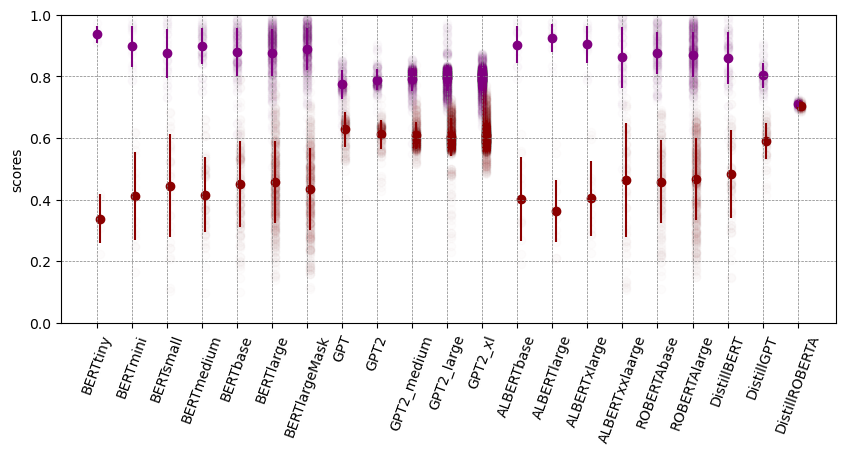

In [244]:
SList = [SBert_tiny, SBert_mini, SBert_small, SBert_medium, SBert_base, SBert_large, SBert_largeMasking,
         SGPT, SGPT2, SGPT2_medium, SGPT2_large, SGPT2_xl,
         SALBERT_base, SALBERT_large, SALBERT_xlarge, SALBERT_xxlarge,
         SROBERTA_base, SROBERTA_large,
         SDistillBERT, SDistillGPT2, SDistillROBERTA
         ]

NList = [NBert_tiny, NBert_mini, NBert_small, NBert_medium, NBert_base, NBert_large, NBert_largeMasking,
         NGPT, NGPT2, NGPT2_medium, NGPT2_large, NGPT2_xl,
         NALBERT_base, NALBERT_large, NALBERT_xlarge, NALBERT_xxlarge,
         NROBERTA_base, NROBERTA_large,
         NDistillBERT, NDistillGPT2, NDistillROBERTA
         ]

names = ['BERTtiny', 'BERTmini', 'BERTsmall', 'BERTmedium', 'BERTbase', 'BERTlarge', 'BERTlargeMask',
         'GPT', 'GPT2', 'GPT2_medium', 'GPT2_large', 'GPT2_xl',
         'ALBERTbase', 'ALBERTlarge', 'ALBERTxlarge', 'ALBERTxxlaarge',
         'ROBERTAbase', 'ROBERTAlarge', 
         'DistillBERT', 'DistillGPT', 'DistillROBERTA'
         ]

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):

    plt.scatter(i*np.ones(SList[i].size),SList[i].flatten(),color='purple',alpha=.01)
    plt.scatter(i,SList[i].flatten().mean(),color='purple')
    plt.errorbar(i,SList[i].flatten().mean(),
                SList[i].flatten().std(),
                color='purple')
    plt.scatter((i+.1)*np.ones(NList[i].size),NList[i].flatten(),color='darkred',alpha=.01)
    plt.scatter(i+.1,NList[i].flatten().mean(),color='darkred')
    plt.errorbar(i+.1,NList[i].flatten().mean(),
                NList[i].flatten().std(),
                color='darkred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)

In [139]:
'DistillBERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 6
d = 768
h = 12

dh = d // h

model = DistilBertModel.from_pretrained("distilbert-base-uncased")
M = get_matricesDistillBERT(model)
SDistillBERT, NDistillBERT = decomposition_blocks(d,l,h,dh,M)

In [140]:
'import BERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 12
d = 1024
h = 16

dh = d // h

model = BartModel.from_pretrained("facebook/bart-large")
M = get_matricesBART(model)
SBART, NBART = decomposition_blocks(d,l,h,dh,M)

(0.0, 1.0)

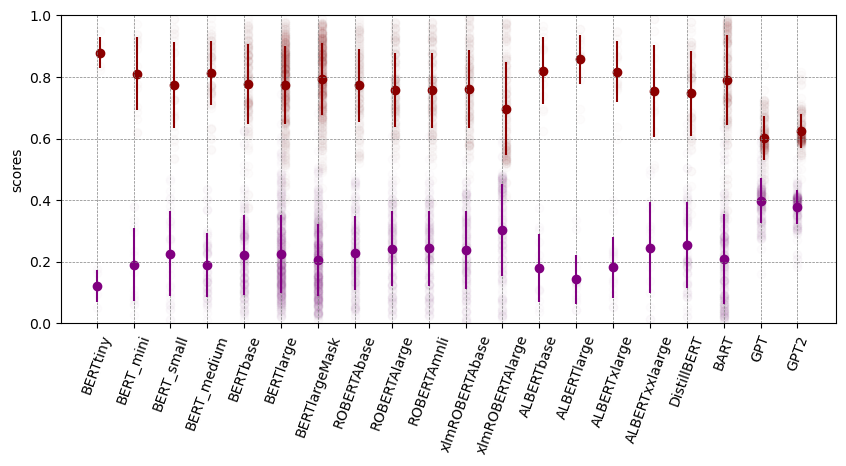

In [188]:

SList = [SBert_tiny, SBert_mini, SBert_small, SBert_medium, SBert_base, SBert_large, SBert_largeMasking,
         SROBERTA_base, SROBERTA_large, SROBERTA_mnli,  SxlmROBERTA_base, SxlmROBERTA_large,
         SALBERT_base, SALBERT_large, SALBERT_xlarge, SALBERT_xxlarge,
         SDistillBERT, 
         SBART,
         SGPT, SGPT2]

NList = [NBert_tiny, NBert_mini, NBert_small, NBert_medium, NBert_base, NBert_large, NBert_largeMasking,
         NROBERTA_base, NROBERTA_large, NROBERTA_mnli, NxlmROBERTA_base, NxlmROBERTA_large,
         NALBERT_base, NALBERT_large, NALBERT_xlarge, NALBERT_xxlarge,
         NDistillBERT, 
         NBART,
         NGPT, NGPT2]

names = ['BERTtiny', 'BERT_mini', 'BERT_small', 'BERT_medium', 'BERTbase', 'BERTlarge', 'BERTlargeMask',
         'ROBERTAbase', 'ROBERTAlarge', 'ROBERTAmnli', 'xlmROBERTAbase', 'xlmROBERTAlarge',
         'ALBERTbase', 'ALBERTlarge', 'ALBERTxlarge', 'ALBERTxxlaarge',
         'DistillBERT', 
         'BART',
         'GPT', 'GPT2']

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):

    plt.scatter(i*np.ones(SList[i].size),SList[i].flatten(),color='purple',alpha=.01)
    plt.scatter(i,SList[i].flatten().mean(),color='purple')
    plt.errorbar(i,SList[i].flatten().mean(),
                SList[i].flatten().std(),
                color='purple')
    plt.scatter((i+.1)*np.ones(NList[i].size),NList[i].flatten(),color='darkred',alpha=.01)
    plt.scatter(i+.1,NList[i].flatten().mean(),color='darkred')
    plt.errorbar(i+.1,NList[i].flatten().mean(),
                NList[i].flatten().std(),
                color='darkred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)